# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#A-basic-OOP-example" data-toc-modified-id="A-basic-OOP-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>A basic OOP example</a></div><div class="lev1 toc-item"><a href="#A-single-reservoir-model" data-toc-modified-id="A-single-reservoir-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A single reservoir model</a></div><div class="lev1 toc-item"><a href="#A-single-reservoir-model-with-inflow" data-toc-modified-id="A-single-reservoir-model-with-inflow-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A single reservoir model with inflow</a></div><div class="lev1 toc-item"><a href="#Coupled-reservoir-model" data-toc-modified-id="Coupled-reservoir-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Coupled reservoir model</a></div>

Damien Delforge, UCLouvain 2018.

# Introduction

Reservoirs are abstract representations of a closable (sub)system able to receive, store and release abstract quantities ruled by some dynamical rules. Typically, reservoirs are widely used in hydrology to represent water or solute exchanges within simple lumped models, usually ruled by a few ordinary differential equation (ODE). This notebook presents how to build your own reservoir model using Object Oriented Programming (OOP). 

In OOP, object are abstraction of real world object described by their `attributes` and able to perform some `methods` based on their attributes. This makes OOP a powerful to make the programming code closer to the conceptual structure of a model. The blueprint of an object is called the `class` and it is used to create many different objects sharing the same `class` but having different `attributes`. For instance, two trees can be defined through the same class `Tree` but can be created with different attributes, such as the Leaf area index (LAI). They also share the same `methods`, such as "photosynthesis" but these are ruled by the `attributes` values, e.g. the LAI. Another example, two reservoir conceptualized within a same `class` can be defined by different geometrical and structural properties as `attributes`. Again, they may share the same methods for discharging water but they will responds the `attributes`. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import sys
print("Python version: {}".format(sys.version_info[:3]))
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("Scipy version: {}".format(sp.__version__))
import matplotlib.pyplot as plt

Python version: (3, 6, 4)
Pandas version: 0.23.4
Numpy version: 1.14.2
Scipy version: 1.0.0


# A basic OOP example

This is a basic `class` example in python:

In [2]:
class MyClass(object):
    
    def __init__(self, myattr):
        self.myattr = myattr
        
    def my_method(self):
        print(self.myattr)

A class is always defined with the keyword `class`, followed by the class name. Between the parenthesis is the `parent` class. In this case, we define our class from the `object` which is the most basic parent. But you may pass the class name of another object, so that the new class will have the same attributes and methods defined by `inheritance`. It is particularly handy if you want to add more precise attributes or methods to an already written class. Each class has an `__init__` method which allows to instanciate (i.e. create) the object. Typically, some values are passed to be stored as attributes (for instance `myattr`). When the keyword `self` is defined as the first argument of a method, it allows to access to the object from the method,  hence, to call attributes and other methods. For instance, the `my_method` method can access the `myattr` attribute thanks to the `self` argument being passed. Let's create an object:

In [3]:
A = MyClass('hello world')
print(A.myattr)
A.my_method()

hello world
hello world


The object was created using the class name. Within the parenthesis, one should put the attributes required for the `__init__` method, so the `__init__` method is automatically called during the instanciation. The `hello world` attributes was passed. Attributes can be accessed with the synthax: `object.attribute`. Same goes for the methods but they need to be called with parenthesis and eventual arguments: `object.method(*args)`.

# A single reservoir model

The following code introduce a single reservoir model. The reservoir dynamic has the following form:

$$
\frac{dS}{dt} = -Q_{out}
$$

with $\frac{dS}{dt}$ the dynamic of the storage $S$ and $Q_{out}$, the outflow. 

The outflow $Q_{out}$ is linearly related to the storage $S$ by the discharge coefficient $k$:

$$
Q_{out} = kS
$$

Such a reservoir can be solved analytically into:

$$
S = S_0 e^{-kt}
$$

where $S_0$ is the initial storage of the reservoir and $t$ is the time.

To represent a reservoir described by the above dynamic within a python object, a generic class can be written. This class can be instanciated with the initial storage $S_0$, the parameter $k$ and $t$, the number of time step to consider for the simulation.

In [4]:
class Reservoir1(object):
    
    def __init__(self, S0, k, t=100):
        """Initialization of the reservoir
        
        Attributes:
        -----------
        
        S0 : float
            Initial storage
        k : float
            Dicharge coefficient
        t : int
            Number of time step to consider (default=100)
        
        """
        
        # set attributes
        self.s0 = S0
        self.k = k
        self.tend = t
        self.tarr = np.arange(t) # time vector
        
        # intitiate ouput storage
        self.output = np.zeros(t)
        self.output[0] = S0
    
    def solve(self):
        """Solve numerically the reservoir ODE
        
        The scipy solver is used stepwise. It is based
        on lsoda routines and suitable for both stiff
        and non stiff problems.
        
        """
        k = self.k
        for i in range(self.tend-1):
            t = [0,1] # unit time step
            s0 = self.output[i]
            sol = odeint(self.ode, s0, t, args=(k,))
            self.output[i+1] = sol[1] # the new storage is at index 1
    
    @property
    def solution(self):
        """Return solution from analytical expression
        
        This method is a property. It is a method but
        it is called like an attribute, without using
        the parenthesis. Ex:
        
        >>> myres = Reservoir1(10, 0.1)
        >>> myres.solution
        
        """
        t = self.tarr
        S0 = self.s0
        k = self.k
        return S0*np.exp(-k*t)
    
    @staticmethod
    def ode(s, t, k):
        """Ordinary differential equation
        
        This method has to be static, i.e. not bound the class.
        In other words, we cannot call method and attributes and
        they need to be explicitely passed as variables and
        parameters:
        
        - First element is always the output variables.
        - Second element is always time.
        - Last elements are input variables or parameters.
        """
        dSdt = -k*s
        return dSdt
    

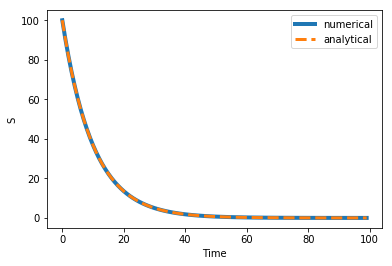

In [5]:
# Instantiate reservoir
res1 = Reservoir1(100, 0.1)

# Solve reservoir
res1.solve()

# Plot results
fig = plt.figure()
ax = fig.gca() # get current axes
ax.plot(res1.output, label='numerical', lw=4)
ax.plot(res1.solution, label='analytical', lw=3, ls='--')
ax.set_xlabel('Time')
ax.set_ylabel('S')
ax.legend()

# A single reservoir model with inflow

In this case, the reservoir is subject to a constant inflow. The continuity equation is then given by:

$$
\frac{dS}{dt} = Q_{in} - Q_{out}
$$

with $Q_{in}$ the constant inflow term. Still, the continuity equation has a solution (because Q_in is constant) given by the expression:

$$
S = \frac{Q_{in}}{k} + (S_0 - \frac{Q_{in}}{k})e^{-kt}
$$

In this slightly modified version, inflow is considered and passed as an argument in once instanciating the object.

In [6]:
class Reservoir2(object):
    
    def __init__(self, S0, k, inflow, t=100):
        """Initialization of the reservoir
        
        Attributes:
        -----------
        
        S0 : float
            Initial storage
        k : float
            Dicharge coefficient
        inflow : numpy.array
            Numpy 1D array with the inflow. Should be of length
            `t`.
        t : int
            Number of time step to consider (default=100)
        
        """
        
        # set attributes
        self.s0 = S0
        self.k = k
        self.tend = t
        self.tarr = np.arange(t)
        self.inflow = inflow
        
        # intitiate ouput storage
        self.output = np.zeros(t)
        self.output[0] = S0
    
    def solve(self):
        """Solve numerically the reservoir ODE"""
        k = self.k
        for i in range(self.tend-1):
            t = [0,1] # unit time step
            s0 = self.output[i]
            qin = self.inflow[i]
            sol = odeint(self.ode, s0, t, args=(k,qin))
            self.output[i+1] = sol[1]
    
    @property
    def solution(self):
        """Return solution from analytical expression"""
        t = self.tarr
        S0 = self.s0
        k = self.k
        qin = self.inflow
        return qin/k + (S0-qin/k)*np.exp(-k*t)
    
    @staticmethod
    def ode(s, t, k, qin):
        """Ordinary differential equation
        """
        dSdt = qin-k*s
        return dSdt
    

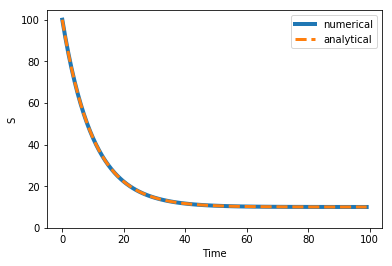

In [7]:
qin = np.ones(100)
# Instantiate reservoir
res1 = Reservoir2(100, 0.1, qin)

# Solve reservoir
res1.solve()

# Plot results
fig = plt.figure()
ax = fig.gca() # get current axes
ax.plot(res1.output, label='numerical', lw=4)
ax.plot(res1.solution, label='analytical', lw=3, ls='--')
ax.set_xlabel('Time')
ax.set_ylabel('S')
ax.set_ylim(0)
ax.legend()

The storage reaches an equilibrium around 10. With a variable inflow, the analytical solution is no longer valid but the reservoir can be solved numerically:

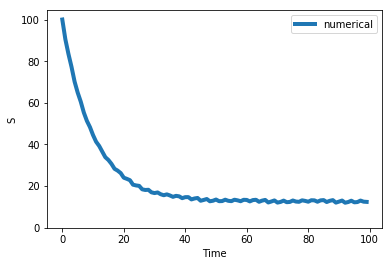

In [8]:
qin = 2*np.abs(np.sin(np.arange(100)))
# Instantiate reservoir
res1 = Reservoir2(100, 0.1, qin)

# Solve reservoir
res1.solve()

# Plot results
fig = plt.figure()
ax = fig.gca() # get current axes
ax.plot(res1.output, label='numerical', lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('S')
ax.set_ylim(0)
ax.legend()

# Coupled reservoir model

In this last case, we define a coupled reservoir model. The first reservoir has no inflow  as defined in the first reservoir class `Reservoir1`. The second is fed by the first one and has a variable inflow such as the second class `Reservoir2`. To link them, we write a class `ReservoirModel` and re-use the previously written reservoir classes. The second reservoir is assumed empty at the beginning so that we only have to initiate the model with the two discharge coefficient $k1$ and $k2$ and $S_0$, the initial storage in the first reservoir.

In [9]:
class ReservoirModel(object):
    
    def __init__(self, S0, k1, k2, t=100):
        """Create a coupled reservoir model
        
        Attributes:
        -----------
        
        S0 : float
            Initial storage in the first reservoir
        k1 : float
            Discharge coefficient of the first reservoir
        k2 : float
            Discharge coefficent of the second reservoir
        t : int
            Number of time step for the simulation
        
        """
        
        self.res1 = Reservoir1(S0, k1, t)
        self.res2 = Reservoir2(0, k2, np.zeros(t))
        self.tend = t
        
        # initiate outputs
        # col1 = S1, col2 = S2
        
        self.outputs = np.zeros((t, 2))
        self.outputs[0,0] = S0
        
    def solve(self):
        
        k1 = self.res1.k
        k2 = self.res2.k
        
        for i in range(self.tend-1):
            
            # solving reservoir 1
            s1 = self.outputs[i, 0]
            sol1 = odeint(self.res1.ode, s1, [0,1], args=(k1,))
            
            # solving reservoir 2
            qin = s1 - sol1[1]
            
            s2 = self.outputs[i, 1]
            sol2 = odeint(self.res2.ode, s2, [0,1], args=(k2, qin))
            
            # store output
            
            self.outputs[i+1, 0] = sol1[1]
            self.outputs[i+1, 1] = sol2[1]
            self.res2.inflow[i] = qin
            

Text(0,0.5,'Storage')

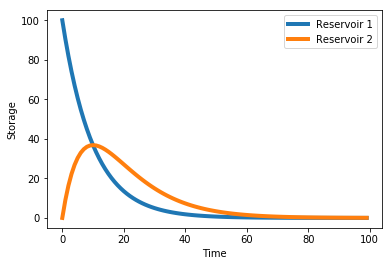

In [10]:
model = ReservoirModel(100, 0.1, 0.1)
model.solve()

fig = plt.figure()
ax = fig.gca()
ax.plot(model.outputs[:,0], label='Reservoir 1', lw=4)
ax.plot(model.outputs[:,1], label='Reservoir 2', lw=4)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Storage')